### Linear Regression

In [42]:
from processing_utils import get_train_data, encode_smiles_column_of, prune_dataset_lines, cross_validation_of
import pandas as pd

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [43]:
raw_dataset = pd.read_csv('./dataset/data.csv')
dataset = encode_smiles_column_of(
    prune_dataset_lines(
        raw_dataset,
        remove_nan_lines=False,
        remove_nan_cols=True,
        remove_duplicates=True,
        in_favour_of_col='Energy_(kcal/mol)'
    ),
    strategy='count_encoding')

#### Performances wrt. training dataset size

In [56]:
from utils import split_array
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from MeanPredictor import MeanPredictor
import random
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np

N_TRIALS = 100
mses = [[] for _ in range(N_TRIALS)]
r2_scores = [[] for _ in range(N_TRIALS)]
percentages = np.arange(0.1, 1, 0.01)

baseline_mses = [[] for _ in range(N_TRIALS)]
baseline_r2_scores = [[] for _ in range(N_TRIALS)]

for k in range(N_TRIALS):
    seed = random.randint(0, 10000)
    random_state = np.random.RandomState(seed)
    #seed = 7732
    for p in percentages:
        # print(f"p={p}, seed={seed}")
        X_train, y_train, X_test, y_test = get_train_data(
            dataset,
            targets_columns=['Energy_(kcal/mol)', 'Energy DG:kcal/mol)'],
            random_state=random_state,
            as_numpy=False,
            validation=False
        )
        rows = np.random.binomial(1, p, size=X_train.shape[0]).astype(bool)

        X_tr = X_train[rows]
        y_tr = y_train[rows]
        #y_tr = y_train.sample(frac=p, random_state=random_state, replace=False)
        
        lr = LinearRegression()
        features_scaler = StandardScaler()
        target_scaler = StandardScaler()
        lr = lr.fit(features_scaler.fit_transform(X_tr),
                    target_scaler.fit_transform(y_tr))
        y_pred = lr.predict(features_scaler.transform(X_test))
        mses[k].append(mean_squared_error(target_scaler.transform(y_test), y_pred))
        r2_scores[k].append(r2_score(target_scaler.transform(y_test), y_pred))


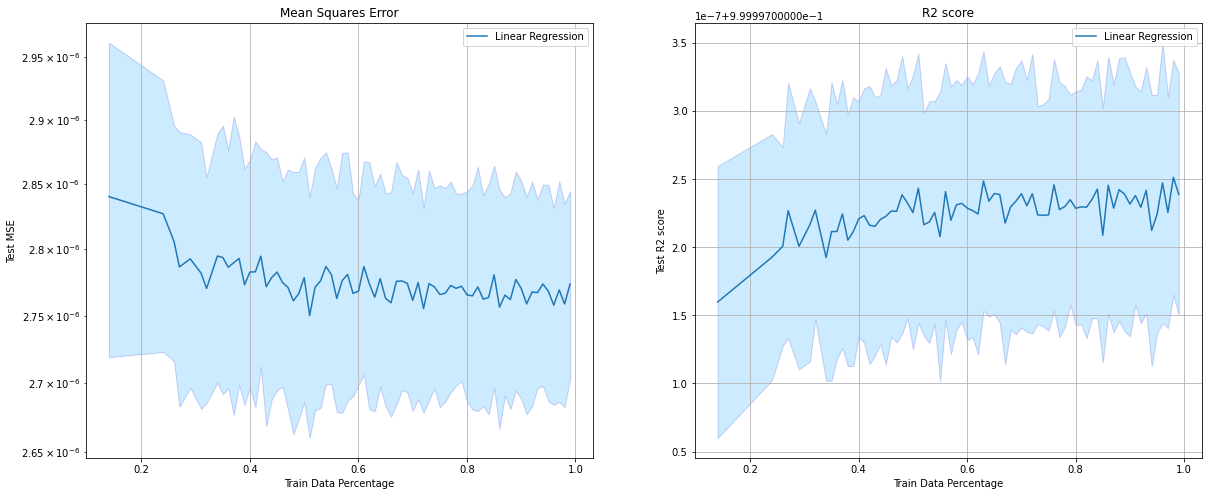

In [66]:
from pathlib import Path

path = Path('./results/linear_regression')

mses = np.array(mses)
r2_scores = np.array(r2_scores)

mses = np.load(path/'linear_reg_mses_var_percentage.npy')
r2_scores = np.load(path/'linear_reg_scores_var_percentage.npy')

np.save(path/'linear_reg_mses_var_percentage', mses)
np.save(path/'linear_reg_scores_var_percentage', r2_scores)

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.title("Mean Squares Error")
plt.xlabel("Train Data Percentage")
plt.ylabel("Test MSE")
plt.grid(True)

final_mses = np.mean(mses, axis=0)
mses_error = np.std(mses, axis=0)

# remove the fucky percentages
rows = np.abs(final_mses) < 10000
final_mses_chosen = final_mses[rows][2:]
mses_error_chosen = mses_error[rows][2:]
percentages_chosen = percentages[rows][2:]

plt.semilogy(percentages_chosen, final_mses_chosen, label='Linear Regression')
plt.legend()
plt.fill_between(percentages_chosen, final_mses_chosen - mses_error_chosen, final_mses_chosen + mses_error_chosen, alpha=0.2, edgecolor='#1B2ACC', facecolor='#089FFF')

plt.subplot(1, 2, 2)
plt.title("R2 score")
plt.xlabel("Train Data Percentage")
plt.ylabel("Test R2 score")
plt.grid(True)
plt.yscale('linear')

final_r2_score = np.mean(r2_scores, axis=0)
r2_score_error = np.std(r2_scores, axis=0)

# remove fucky values
r2_rows = np.abs(final_r2_score) < 10000
final_r2_score_chosen = final_r2_score[r2_rows][2:]
r2_score_error_chosen = r2_score_error[r2_rows][2:]
r2_percentages_chosen = percentages[r2_rows][2:]

plt.plot(r2_percentages_chosen, final_r2_score_chosen, label='Linear Regression')
plt.legend()
plt.fill_between(r2_percentages_chosen, final_r2_score_chosen - r2_score_error_chosen, final_r2_score_chosen + r2_score_error_chosen, alpha=0.2, edgecolor='#1B2ACC', facecolor='#089FFF')

#### Performances wrt. added noise

In [53]:
noisy_mses = [[] for _ in range(N_TRIALS)]
noisy_r2_scores = [[] for _ in range(N_TRIALS)]
scale_factors = np.arange(0.1, 4, 0.1)

for k in range(N_TRIALS):
    for scale_factor in scale_factors:

        seed = random.randint(0, 10000)
        X_train, y_train, X_test, y_test = get_train_data(
            dataset,
            targets_columns=['Energy_(kcal/mol)', 'Energy DG:kcal/mol)'],
            random_state=random_state,
            as_numpy=False,
            validation=False
        )
        
        features_scaler = StandardScaler()
        target_scaler = StandardScaler()
        lr = LinearRegression()

        X_train.iloc[:3] += np.random.normal(scale=scale_factor, size=X_train.iloc[:3].shape)

        lr.fit(features_scaler.fit_transform(X_train), target_scaler.fit_transform(y_train))
        y_pred = lr.predict(features_scaler.transform(X_test))
        
        noisy_mses[k].append(mean_squared_error(target_scaler.transform(y_test), y_pred))
        noisy_r2_scores[k].append(r2_score(target_scaler.transform(y_test), y_pred))

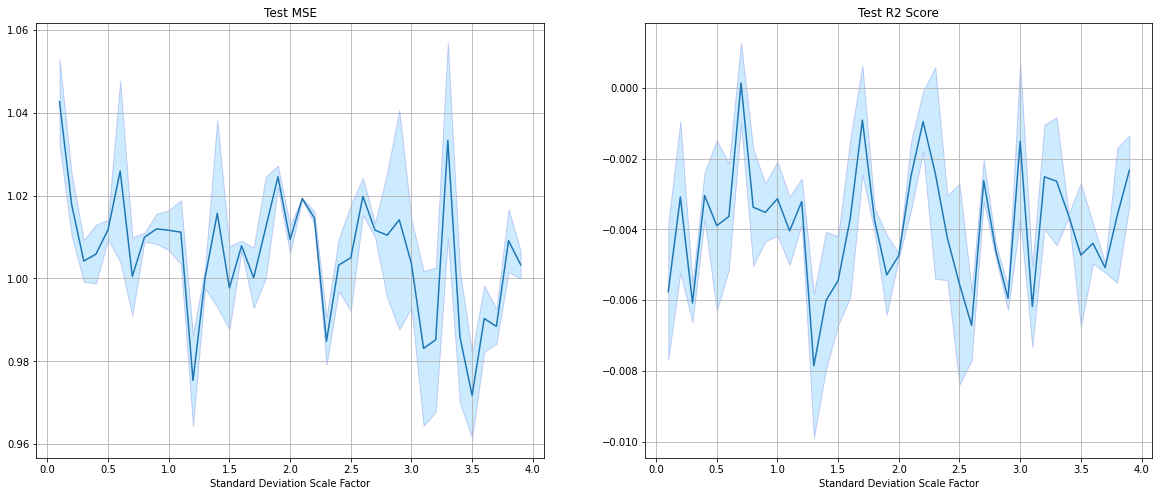

In [54]:
scale_factors = np.arange(0.1, 4, 0.1)

#np.save(path/'linear_reg_mses_var_noise', mses)
#np.save(path/'linear_reg_scores_var_noise', r2_scores)

mses = np.load(path/'linear_reg_mses_var_noise.npy')
r2_scores = np.load(path/'linear_reg_scores_var_noise.npy')

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.title("Test MSE")
plt.xlabel("Standard Deviation Scale Factor")
final_mses = np.mean(mses, axis=0)
mses_error = np.std(mses, axis=0)
plt.grid(True)
plt.plot(scale_factors, final_mses)
plt.fill_between(scale_factors, final_mses - mses_error, final_mses + mses_error, alpha=0.2, edgecolor='#1B2ACC', facecolor='#089FFF')


plt.subplot(1, 2, 2)
plt.title("Test R2 Score")
plt.xlabel("Standard Deviation Scale Factor")
final_r2_score = np.mean(r2_scores, axis=0)
r2_score_error = np.std(r2_scores, axis=0)
plt.grid(True)
plt.plot(scale_factors, final_r2_score)
plt.fill_between(scale_factors, final_r2_score - r2_score_error, final_r2_score + r2_score_error, alpha=0.2, edgecolor='#1B2ACC', facecolor='#089FFF')